# Parallelization using numba
In this notebook we will optimize execution time of an algorithm by using [numba](https://numba.pydata.org/).

In [1]:
import time
import numpy as np
from functools import partial
import timeit
import matplotlib.pyplot as plt
import platform

In [2]:
image = np.zeros((10, 10))

## Benchmarking execution time
In image processing, it is very common that execution time of algorithms shows different patterns depending on image size. We will now benchmark the algorithm above and see how it performs on differently sized images.
To bind a function to benchmark to a given image without executing it, we are using the [partial](https://docs.python.org/3/library/functools.html#functools.partial) pattern.

In [3]:
def benchmark(target_function):
    """
    Tests a function on a couple of image sizes and returns times taken for processing.
    """
    sizes = np.arange(1, 5) * 10

    benchmark_data = []

    for size in sizes:
        print("Size", size)

        # make new data
        image = np.zeros((size, size))
        
        # bind target function to given image
        partial_function = partial(target_function, image)

        # measure execution time
        time_in_s = timeit.timeit(partial_function, number=10)
        print("time", time_in_s, "s")

        # store results
        benchmark_data.append([size, time_in_s])

    return np.asarray(benchmark_data)

This is the algorithm we would like to optimize:

In [4]:
def silly_sum(image):
    # Silly algorithm for wasting compute time
    sum = 0
    for i in range(image.shape[1]):
        for j in range(image.shape[0]):
            for k in range(image.shape[0]):
                for l in range(image.shape[0]):
                    sum = sum + image[i,j] - k + l
        sum = sum + i
        image[i, j] = sum / image.shape[1] / image.shape[0]

In [5]:
benchmark_data_silly_sum = benchmark(silly_sum)

Size 10
time 0.026225900000000024 s
Size 20
time 0.3880397999999996 s
Size 30
time 2.4635917000000003 s
Size 40
time 6.705509999999999 s


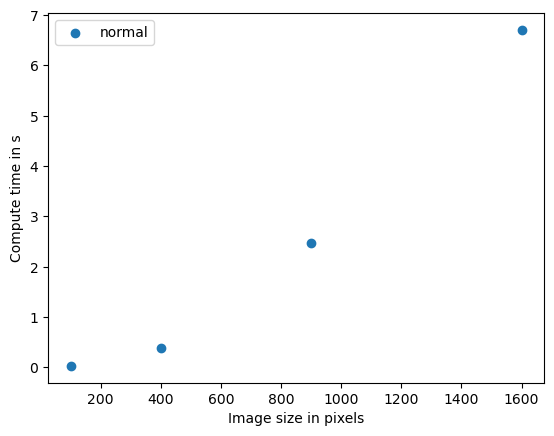

In [6]:
plt.scatter(benchmark_data_silly_sum[:,0] ** 2, benchmark_data_silly_sum[:,1])
plt.legend(["normal"])
plt.xlabel("Image size in pixels")
plt.ylabel("Compute time in s")
plt.show()

This algorithm is stronger dependent on image size, the plot shows approximately [quadratic](https://en.wikipedia.org/wiki/Time_complexity#Table_of_common_time_complexities) complexity. That means if the data size doubles, the compute time multiplies by four. The algorithms O-notation is `O(n^2)`. We could presume that a similar algorithm applied in 3D has cubic complexity, `O(n^3)`. If such algorithms are bottlenecks in your science, parallelization and GPU-acceleration make a lot of sense.

## Code optimization using numba
In case the code we perform is simple and just uses standard python, numpy etc. function, we can use a just-in-time (JIT) compiler, e.g. provided by [numba](https://numba.pydata.org/) to speedup the code.

In [7]:
from numba import jit

@jit
def process_image_compiled(image):
    for x in range(image.shape[1]):
        for y in range(image.shape[1]):
            # Silly algorithm for wasting compute time
            sum = 0
            for i in range(1000):
                for j in range(1000):
                    sum = sum + x
                sum = sum + y
            image[x, y] = sum

In [8]:
%timeit process_image_compiled(image)

The slowest run took 56.00 times longer than the fastest. This could mean that an intermediate result is being cached.
2.84 µs ± 5.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
